In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

## Initial Data Cleanup

In [3]:
out_dir = '/glade/work/afoster/ECOSTRESS_data'
zonal_data_file = os.path.join(out_dir, 'AFoster_data_merged_with_zonal.csv')

In [4]:
# read in data file and calculate the binned density
df = pd.read_csv(zonal_data_file)
df['dens_ha_binned'] = df['tree_ct']/df['calc_hectares']

# split off the time string part of the raster file name
df['time_string'] = [str(file).replace('SAN_LST_', '').replace('.tif', '') for file in df['raster_file']]

# drop nans
df = df.dropna()

In [5]:
# getting some mal-formed rows... let's drop for now
bad = df[~df['time_string'].str.match(r'^\d{4}_\d{2}_\d{2}_\d{6}$')]
print(bad['time_string'])

170       2021_09_20_1802221
498       2021_09_20_1802221
826       2021_09_20_1802221
1155      2021_09_20_1802221
1480      2021_09_20_1802221
                 ...        
642757    2021_09_20_1802221
643100    2021_09_20_1802221
643443    2021_09_20_1802221
643786    2021_09_20_1802221
644129    2021_09_20_1802221
Name: time_string, Length: 1826, dtype: object


In [6]:
# drop mal-formed rows
df = df[df['time_string'].str.match(r'^\d{4}_\d{2}_\d{2}_\d{6}$')]

# make datetime object
df['datetime'] = pd.to_datetime(df['time_string'], format='%Y_%m_%d_%H%M%S')

In [31]:
df['day_of_year'] = df.datetime.dt.dayofyear
df['hour'] = df.datetime.dt.hour
df['year'] = df.datetime.dt.year

In [39]:
df_grouped = pd.DataFrame(df.groupby([df.day_of_year, df.hour, df.site_id]).mean_C.mean()).reset_index()

In [51]:
summer = df_grouped[df_grouped.day_of_year.isin(np.arange(152, 243))]
summer_afternoon = summer[summer.hour.isin(np.arange(12, 15)]

In [ ]:
clusters = np.unique(summer_afternoon.cluster)
for cluster in clusters:
    cluster_dat = summer_afternoon[summer_afternoon.cluster == cluster]
    plt.hist(cluster_dat.mean_C, label=cluster)

(array([  1.,  25.,   9.,  13.,  21., 172., 488., 532., 134.,  12.]),
 array([ 8.11315217, 13.06902564, 18.0248991 , 22.98077256, 27.93664602,
        32.89251948, 37.84839295, 42.80426641, 47.76013987, 52.71601333,
        57.67188679]),
 <BarContainer object of 10 artists>)

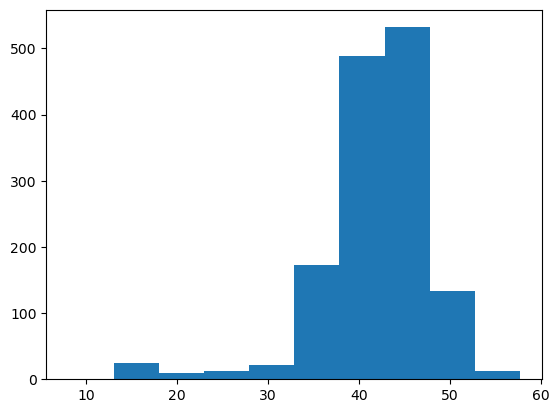

In [56]:
plt.hist(summer_afternoon.mean_C)

In [58]:
mean_temp = df.groupby(df.cluster).mean_C.mean()


AttributeError: 'DataFrame' object has no attribute 'cluster'

## Clustering

In [53]:
# we have duplicates for some of these sites - I think I remember that the polygons are different?
# let's check on these
df_stand_struct = df[['site_id', 'z_bin_hgtcateg', 'dens_ha_binned']].drop_duplicates()

# count how many times each (site_id, z_bin_hgtcateg) pair occurs
counts = df_stand_struct.groupby(['site_id', 'z_bin_hgtcateg']).cumcount()

# append the count to site_id to make it unique when necessary - make a new site_id column
df_stand_struct['site_id_unique'] = df_stand_struct['site_id'].astype(str) + '_dup' + counts.astype(str)

In [101]:
# pivot
df_wide = df_stand_struct.pivot(index='site_id_unique', columns='z_bin_hgtcateg', values='dens_ha_binned').fillna(0)
col_order = ['(0,5]', '(5,10]', '(10,15]', '(15,20]', '(20,25]', '(25,30]', '(30,35]', '(35,40]']
df_pivot = df_wide[col_order]

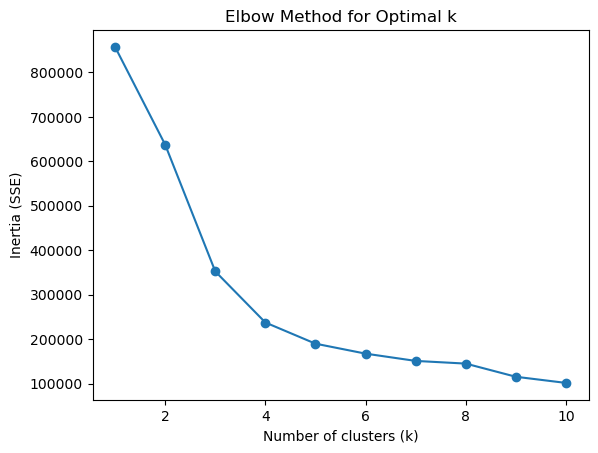

In [103]:
# pick how many clusters
inertia = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(df_pivot)
    inertia.append(km.inertia_)

plt.figure()
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

In [104]:
k = 4

X = df_pivot.values
kmeans = KMeans(n_clusters=k, random_state=0)
df_pivot['cluster'] = kmeans.fit_predict(X)

/glade/derecho/scratch/afoster/tmp/ipykernel_128370/248730401.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pivot['cluster'] = kmeans.fit_predict(X)


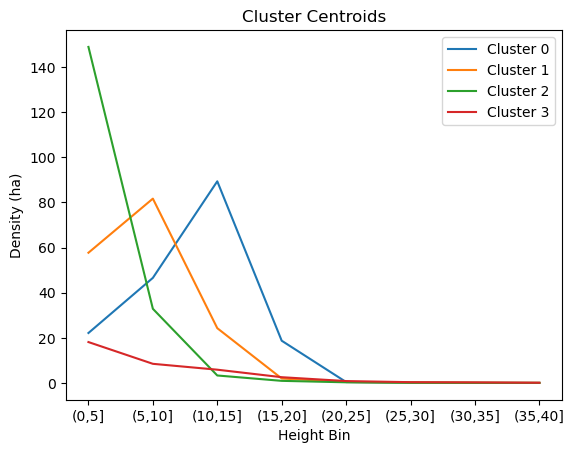

In [106]:
centroids = kmeans.cluster_centers_
z_bins = df_pivot.columns[:-1]  # exclude 'cluster' column

for i, c in enumerate(centroids):
    plt.plot(z_bins, c, label=f'Cluster {i}')

plt.xlabel("Height Bin")
plt.ylabel("Density (ha)")
plt.title("Cluster Centroids")
plt.legend()
plt.show()

In [118]:
df_long = df_pivot.reset_index().melt(
    id_vars=['site_id_unique', 'cluster'],
    var_name='height_bin',
    value_name='density'
)
df_long['cluster'] = df_long['cluster'].astype('category')

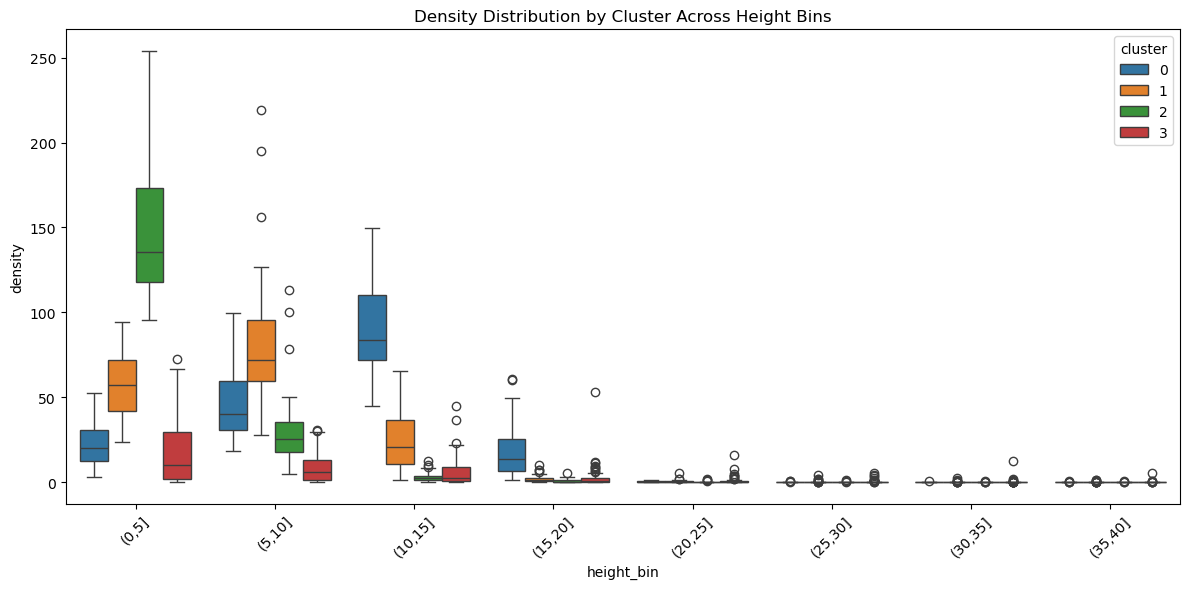

In [126]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_long,
    x='height_bin',
    y='density',
    hue='cluster',
)
plt.xticks(rotation=45)
plt.title('Density Distribution by Cluster Across Height Bins')
plt.tight_layout()
plt.show()

In [ ]:
## So here it looks like:
## cluster 0 larger trees
## cluster 1 is medium trees
## cluster 2 is high density of small trees
## cluster 3 is low density of small trees